# Introduction 

The objective of this notebook is to predict whether it will rain the next day with the weather conditions of the current day. The dataset we will use is weatherAUS.csv, which contains 160689 entries of weather data between 2007 and 2017 at 49 locations in Australia. As geographical factors play vital roles in weather conditions, we will import geo-coordinates of the locations from worldcitiespop dataset and geocoding API to better capture the feature, and therefore make more accurate predictions. <br>
There are four sections in this notebook: <br>
* Import and Join Data
* Deal with Missing Values
* Exploratory Data Analysis
* Make Prediction with XGBoost

In [84]:
# import libraries and environment setting 
import numpy as np 
import pandas as pd 
import missingno as msno
from math import floor
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import re
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import  plot_confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_theme()
sns.set_palette('colorblind')


# Import and Join Data

Import weatherAUS and worldcitiespop datasets, we will extract the GPS coordinates from the latter one.

In [85]:
df = pd.read_csv('/kaggle/input/weather-dataset-rattle-package/weatherAUS.csv')
coordinates = pd.read_csv('../input/world-cities-database/worldcitiespop.csv',usecols = ['Country','AccentCity','Latitude','Longitude'])
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [86]:
coordinates = coordinates[coordinates.Country=='au'].drop(['Country'],axis = 1)
coordinates.head()

,AccentCity,Latitude,Longitude
150880,Abbotsford,-33.850000,151.133333
150881,Abbotsford,-37.800000,145.000000
150882,Abbotsham,-41.216667,146.183333
150883,Abbotts,-26.316667,118.383333
150884,Abercorn,-25.150000,151.033333


Extract the rows of locations in Australia, and join two data frames on Location and AccentCity.


In [87]:
df = df.merge(coordinates,how = 'left', left_on='Location', right_on='AccentCity')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160689 entries, 0 to 160688
Data columns (total 26 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           160689 non-null  object 
 1   Location       160689 non-null  object 
 2   MinTemp        159135 non-null  float64
 3   MaxTemp        159384 non-null  float64
 4   Rainfall       157241 non-null  float64
 5   Evaporation    93334 non-null   float64
 6   Sunshine       81379 non-null   float64
 7   WindGustDir    150152 non-null  object 
 8   WindGustSpeed  150221 non-null  float64
 9   WindDir9am     147360 non-null  object 
 10  WindDir3pm     156101 non-null  object 
 11  WindSpeed9am   158791 non-null  float64
 12  WindSpeed3pm   157513 non-null  float64
 13  Humidity9am    157800 non-null  float64
 14  Humidity3pm    155981 non-null  float64
 15  Pressure9am    145524 non-null  float64
 16  Pressure3pm    145545 non-null  float64
 17  Cloud9am       97175 non-null

There are still some locations with missing coordinates, for which we will get with Positionstack Geocoding API below.

In [88]:
locations = df.Location[df.Latitude.isna()].unique()
locations

array(['BadgerysCreek', 'CoffsHarbour', 'NorahHead', 'NorfolkIsland',
       'SydneyAirport', 'WaggaWagga', 'MountGinini', 'MelbourneAirport',
       'Nhil', 'GoldCoast', 'MountGambier', 'PearceRAAF', 'PerthAirport',
       'SalmonGums', 'AliceSprings', 'Uluru'], dtype=object)

In [89]:
params = {'access_key':'b8a7f574448bf69e3fa2fe41cc5e4fa8','country':'AU'} 
base_url = 'http://api.positionstack.com/v1/forward'
for address in locations:
    if address == 'PearceRAAF':
        query_address ='RAAF Base Pearce'
    else:
        query_address = ' '.join(re.findall('[A-Z][a-z]*', address))
    params['query'] =  query_address
    response = requests.get(base_url, params = params).json()
    try:
        df.loc[df.Location==address,'Latitude'] = response['data'][0]['latitude']
        df.loc[df.Location==address,'Longitude'] = response['data'][0]['longitude']
    except:
        print(params)
        print(response)
        break


# Deal with Missing Values

Plot missing values with msno.

Date                 0
Location             0
MinTemp           1554
MaxTemp           1305
Rainfall          3448
Evaporation      67355
Sunshine         79310
WindGustDir      10537
WindGustSpeed    10468
WindDir9am       13329
WindDir3pm        4588
WindSpeed9am      1898
WindSpeed3pm      3176
Humidity9am       2889
Humidity3pm       4708
Pressure9am      15165
Pressure3pm      15144
Cloud9am         63514
Cloud3pm         67162
Temp9am           1935
Temp3pm           3748
RainToday         3448
RainTomorrow      3454
AccentCity       45393
Latitude             0
Longitude            0
dtype: int64

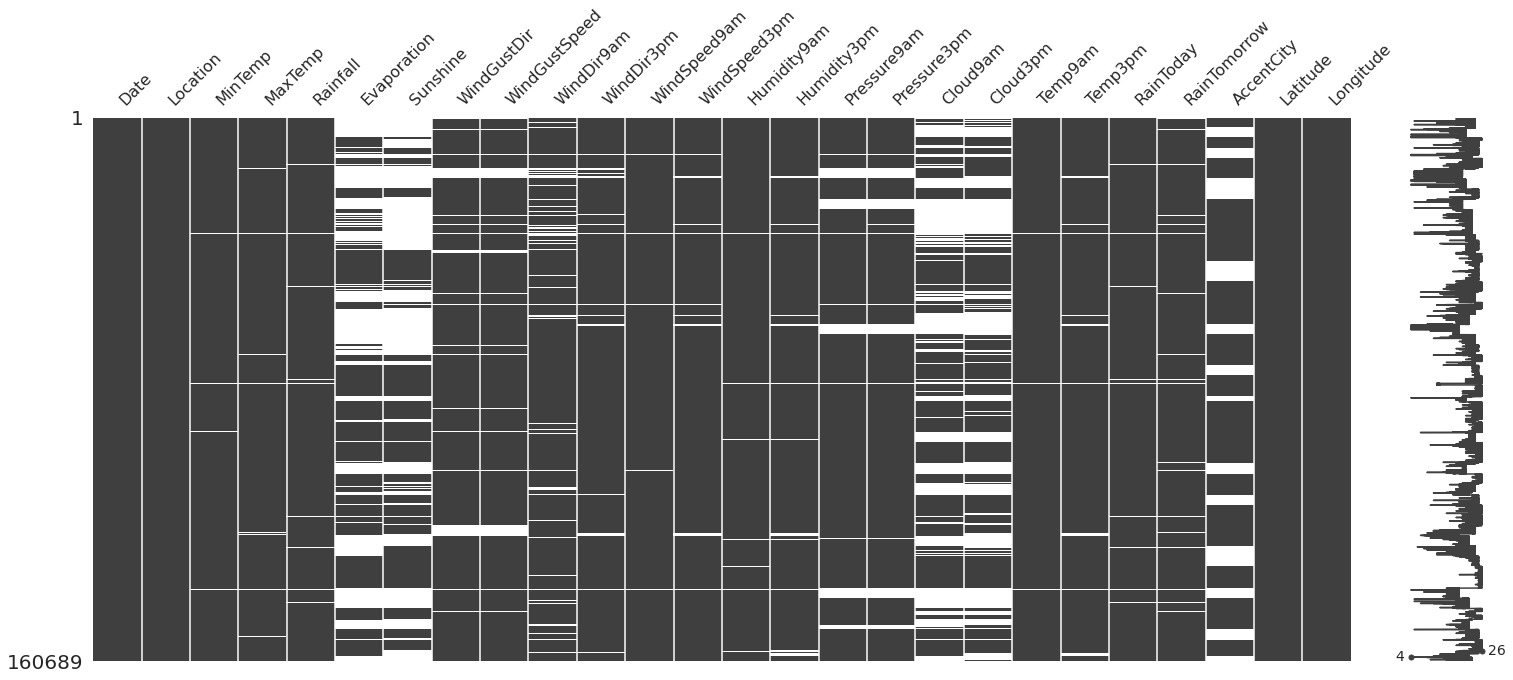

In [91]:
msno.matrix(df)
df.isna().sum()

Columns with a high number of missing values will be dropped, which are "Evaporation", "Sunshine", "Cloud9am", and "Cloud3pm". <br />  And we will extract year and day of year from Date.


In [92]:
df.drop(["Evaporation","Sunshine","Cloud9am","Cloud3pm","AccentCity"], axis = 1, inplace = True)
df.dropna(axis=0,subset=['RainTomorrow'], inplace= True)
df['Year'] = pd.to_datetime(df['Date']).dt.year
df['Day_of_year'] = pd.to_datetime(df['Date']).dt.dayofyear


Here we sort the data by location and time, then fill the missing values with forward fill. 

In [93]:
df.sort_values(by = ['Location','Year','Day_of_year'],inplace = True)
df.fillna(method = 'ffill', limit = 10, inplace = True)

Now that we have aquired geo-corrdinates and transformed Date into desired formats, we can drop "Location" and "Date". <br>
The rows with missing values left will be deleted as well.

In [94]:
df.drop(["Location", "Date"], axis =1,inplace= True)
df.dropna(axis=0,how="any",inplace= True)
df.reset_index(drop = True, inplace = True)
df.isna().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
Latitude         0
Longitude        0
Year             0
Day_of_year      0
dtype: int64

# Exploratory Data Analysis

First of all, let's check out the target variable 'RainTomorrow', then inspect the distribution of numeric and categorial preditor variables.

(137784, 21)
No     0.777187
Yes    0.222813
Name: RainTomorrow, dtype: float64


<AxesSubplot:xlabel='RainTomorrow', ylabel='count'>

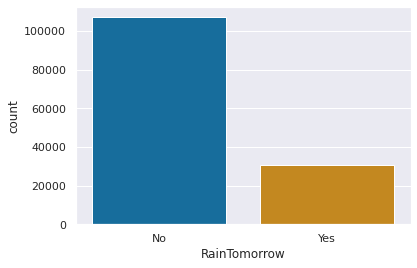

In [95]:
print(df.shape)
print(df['RainTomorrow'].value_counts(normalize = True))
sns.countplot(x='RainTomorrow', data=df)


* There are 99581 observations and 21 columns left.
* RainTomorrow is positive in 22% of entries.

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,Latitude,Longitude,Year,Day_of_year
count,137784.000000,137784.000000,137784.000000,137784.000000,137784.000000,137784.00000,137784.000000,137784.000000,137784.000000,137784.000000,137784.000000,137784.000000,137784.000000,137784.000000,137784.000000,137784.000000
mean,12.290758,23.471633,2.330954,39.769494,13.927894,18.78708,68.869455,51.006278,1017.699530,1015.289734,17.111215,21.972728,-32.943264,142.568236,2012.746037,179.366022
std,6.300587,6.933715,8.392996,13.495443,8.805677,8.67630,19.055446,20.557792,7.108401,7.021910,6.346158,6.780271,6.474800,10.500127,2.527667,104.925386
min,-8.200000,2.600000,0.000000,6.000000,0.000000,0.00000,0.000000,0.000000,980.500000,977.100000,-3.100000,1.700000,-42.883209,115.100000,2007.000000,1.000000
25%,7.700000,18.100000,0.000000,31.000000,7.000000,13.00000,57.000000,36.000000,1013.000000,1010.500000,12.400000,16.800000,-37.562660,140.775335,2011.000000,88.000000
50%,12.100000,22.900000,0.000000,37.000000,13.000000,19.00000,70.000000,51.000000,1017.700000,1015.300000,16.800000,21.400000,-34.033333,145.841827,2013.000000,176.000000
75%,16.900000,28.400000,0.600000,48.000000,19.000000,24.00000,83.000000,65.000000,1022.500000,1020.000000,21.600000,26.700000,-31.498730,149.841568,2015.000000,270.000000
max,33.900000,48.100000,371.000000,135.000000,87.000000,87.00000,100.000000,100.000000,1041.000000,1039.600000,40.200000,46.700000,-12.457220,153.427250,2017.000000,366.000000


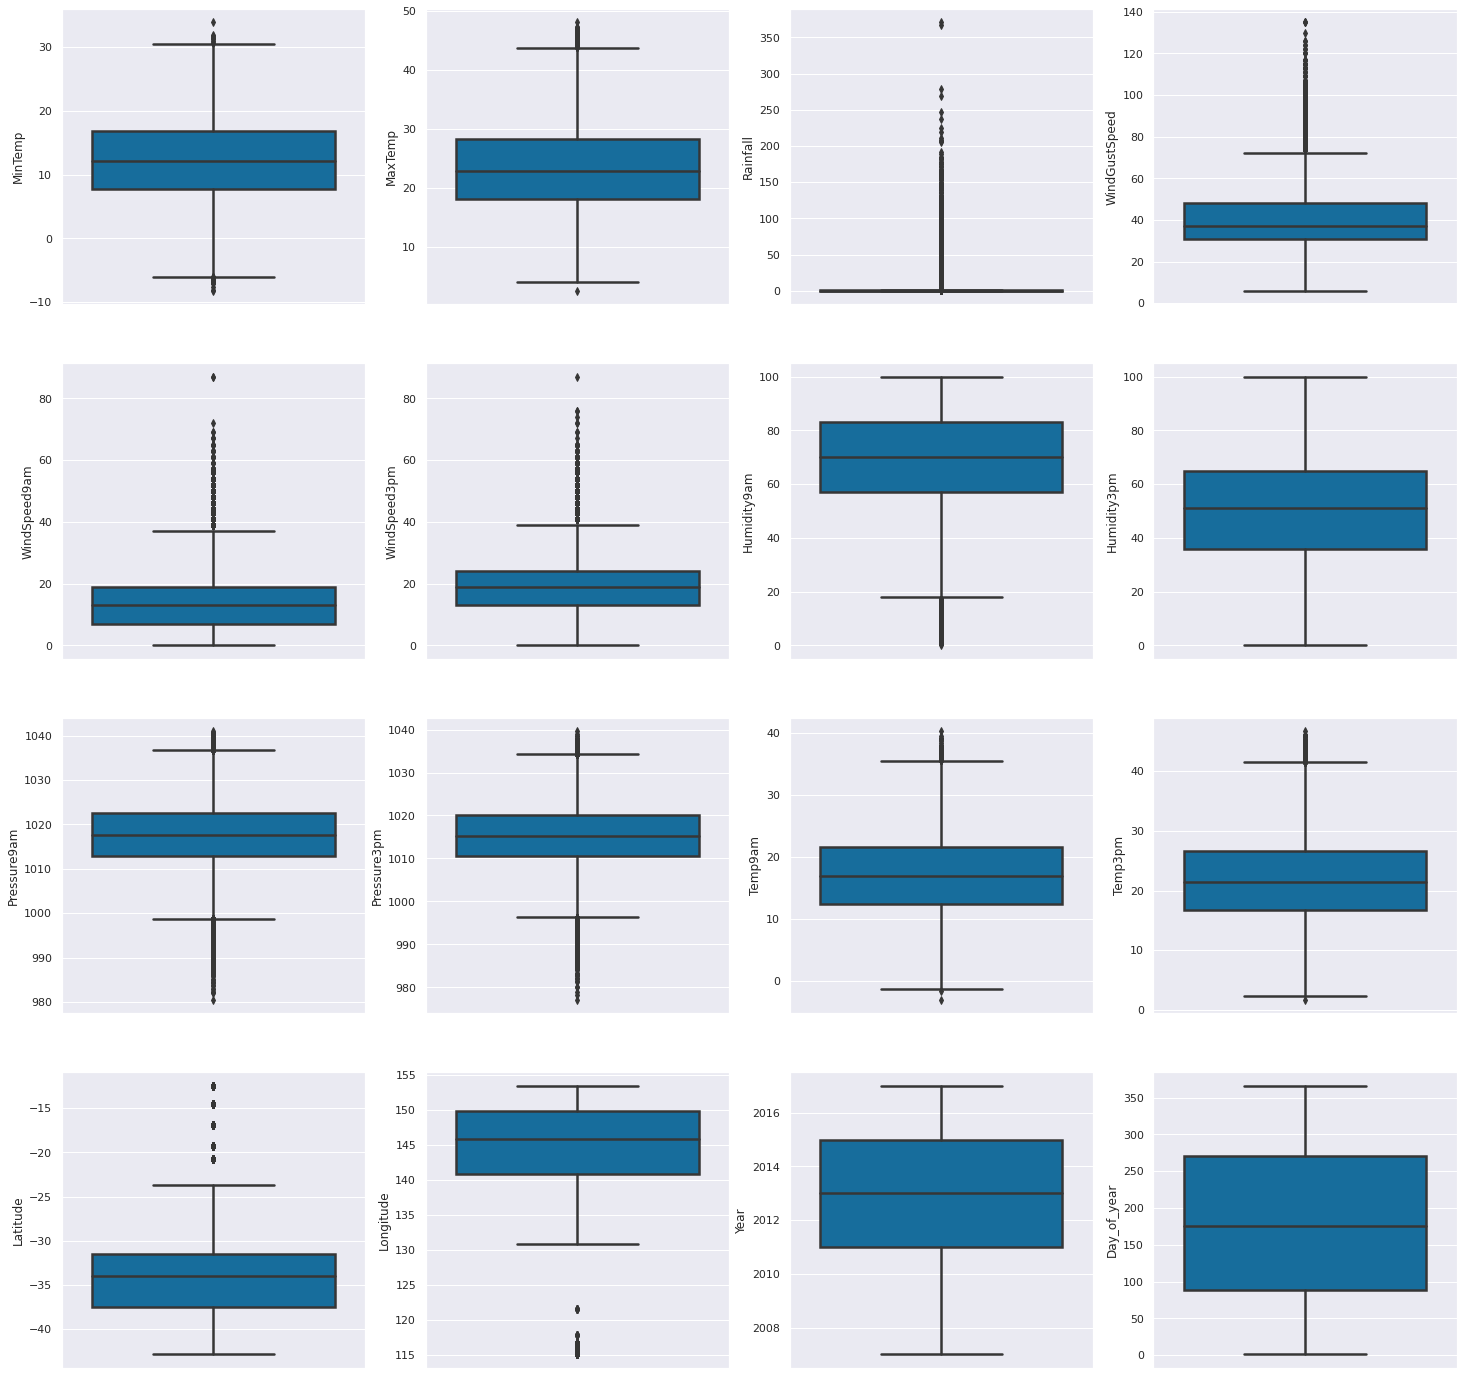

In [96]:
cat_cols = df.columns[(df.dtypes=='O') & (df.columns!='RainTomorrow')]
num_cols = df.columns[df.dtypes!='O']

fig, axes = plt.subplots(4,4,figsize=(25, 25))
for i,col in enumerate(num_cols):
    plt_col = i%4
    plt_row = floor(i/4)
    sns.boxplot(ax = axes[plt_row,plt_col], data = df, y = col, linewidth=2.5)
df.describe()

* Rainfall and WindGustSpeed have some extreme values, which could be caused by extreme weather conditions.
* The majority of observations are located in the Southeastern area of Australia, the most densely populated region of the country.


In [97]:
for col in cat_cols:
    print('Column','"'+ col +'"', 'has', df[col].nunique(),'unique values:\n' )
    print(df[col].value_counts(), '\n\n------------------------------\n')

Column "WindGustDir" has 16 unique values:

W      10478
SE      9972
E       9623
SW      9492
WSW     9284
SSW     9121
S       9120
SSE     9063
N       8955
ENE     8423
WNW     8267
ESE     7901
NW      7618
NE      7615
NNE     6541
NNW     6311
Name: WindGustDir, dtype: int64 

------------------------------

Column "WindDir9am" has 16 unique values:

N      11893
SSE     9659
E       9591
S       9199
SE      9094
SW      8884
NNE     8871
ENE     8370
SSW     8346
NE      8252
NNW     7948
ESE     7839
W       7817
NW      7808
WSW     7119
WNW     7094
Name: WindDir9am, dtype: int64 

------------------------------

Column "WindDir3pm" has 16 unique values:

SE     10105
W       9985
S       9646
WSW     9488
SW      9369
SSE     9246
N       8619
WNW     8499
NE      8417
SSW     8340
ESE     8276
E       8269
ENE     8159
NW      7588
NNW     7252
NNE     6526
Name: WindDir3pm, dtype: int64 

------------------------------

Column "RainToday" has 2 unique values:

No     10

* Wind directions are encoded as 16 values.
* The proportion of "RainToday" is similar to "RainTomorrow", which makes sense.

we will explore the effects of predictor variables on the target variable below.

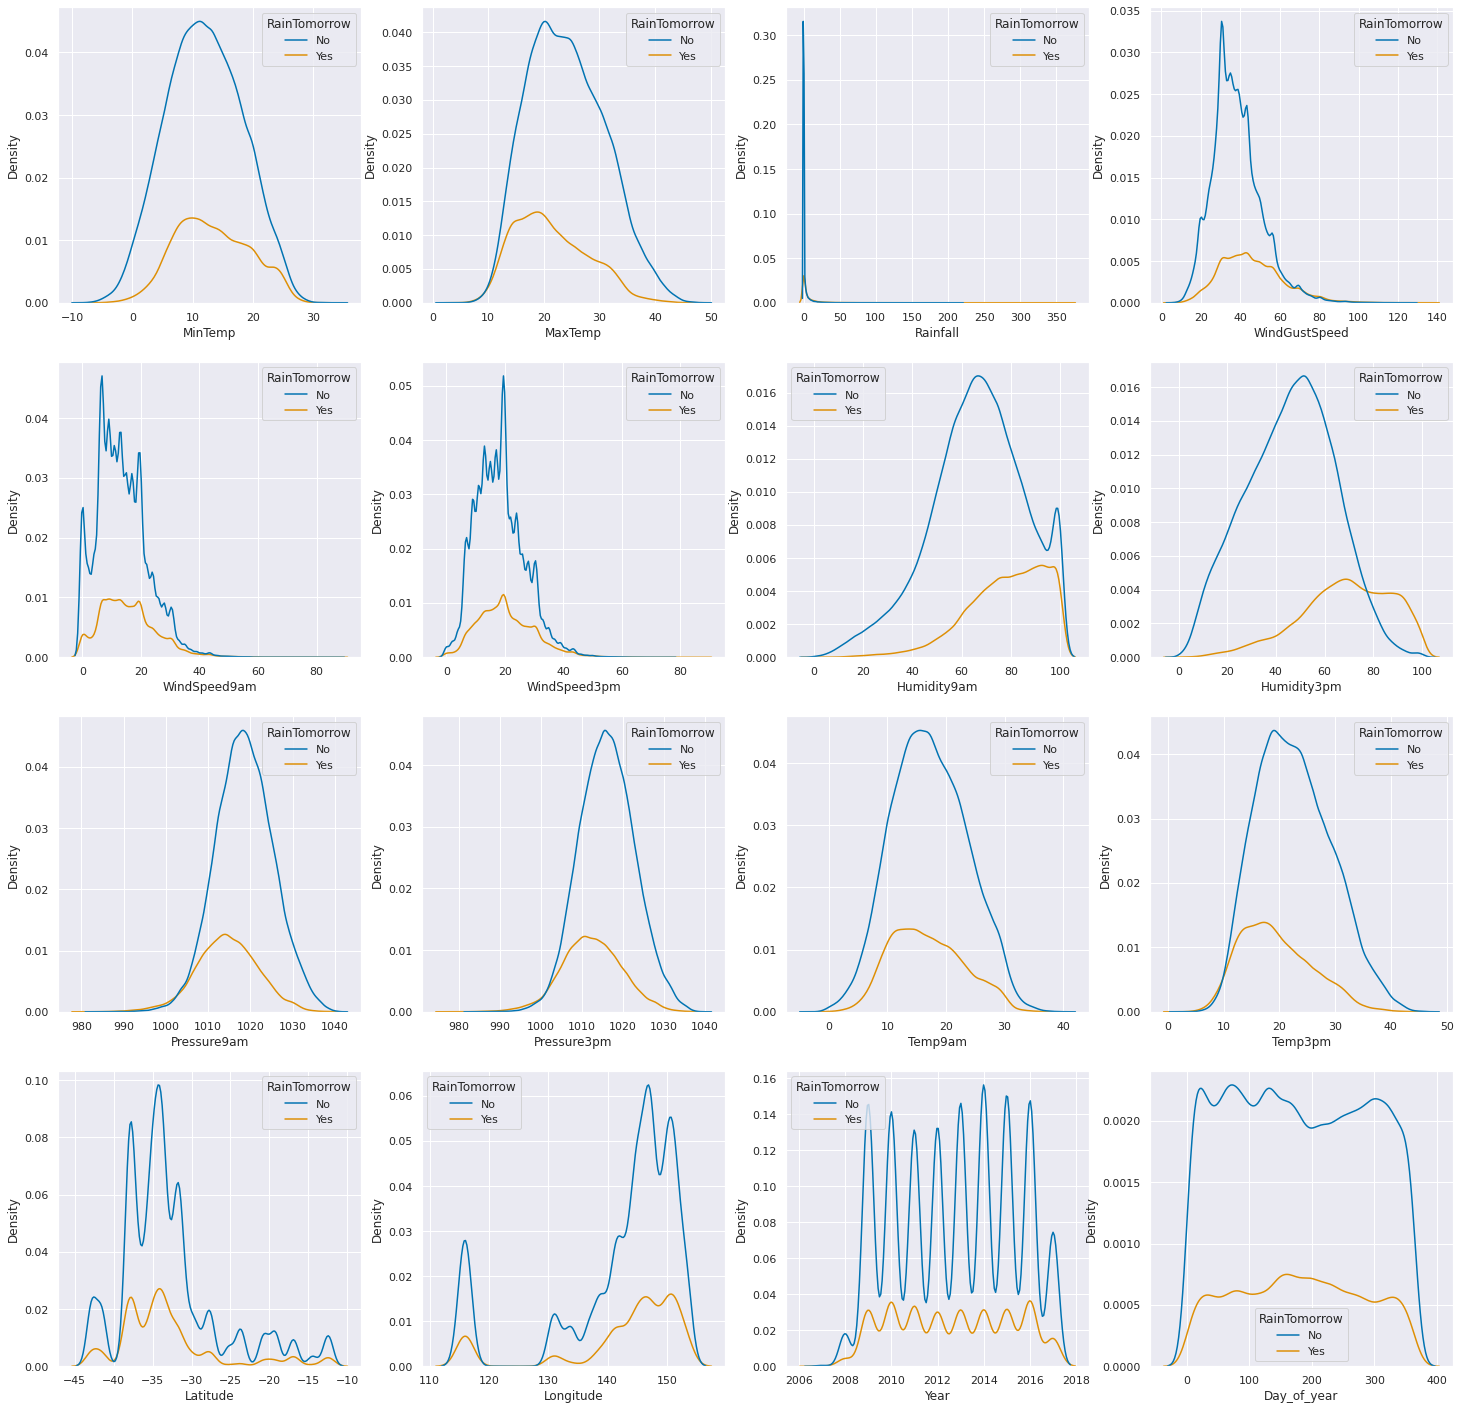

In [98]:
fig, axes = plt.subplots(4,4,figsize=(25, 25))
for i,col in enumerate(num_cols):
    plt_col = i%4
    plt_row = floor(i/4)
    sns.kdeplot(ax = axes[plt_row,plt_col], data = df, x = col, hue = "RainTomorrow")

* Humidity in the afternoon is an effective predictor of RainTomorrow.
* The chance of rain is slightly higher in the middle of the year, which is winter in the souther hemisphere.


<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

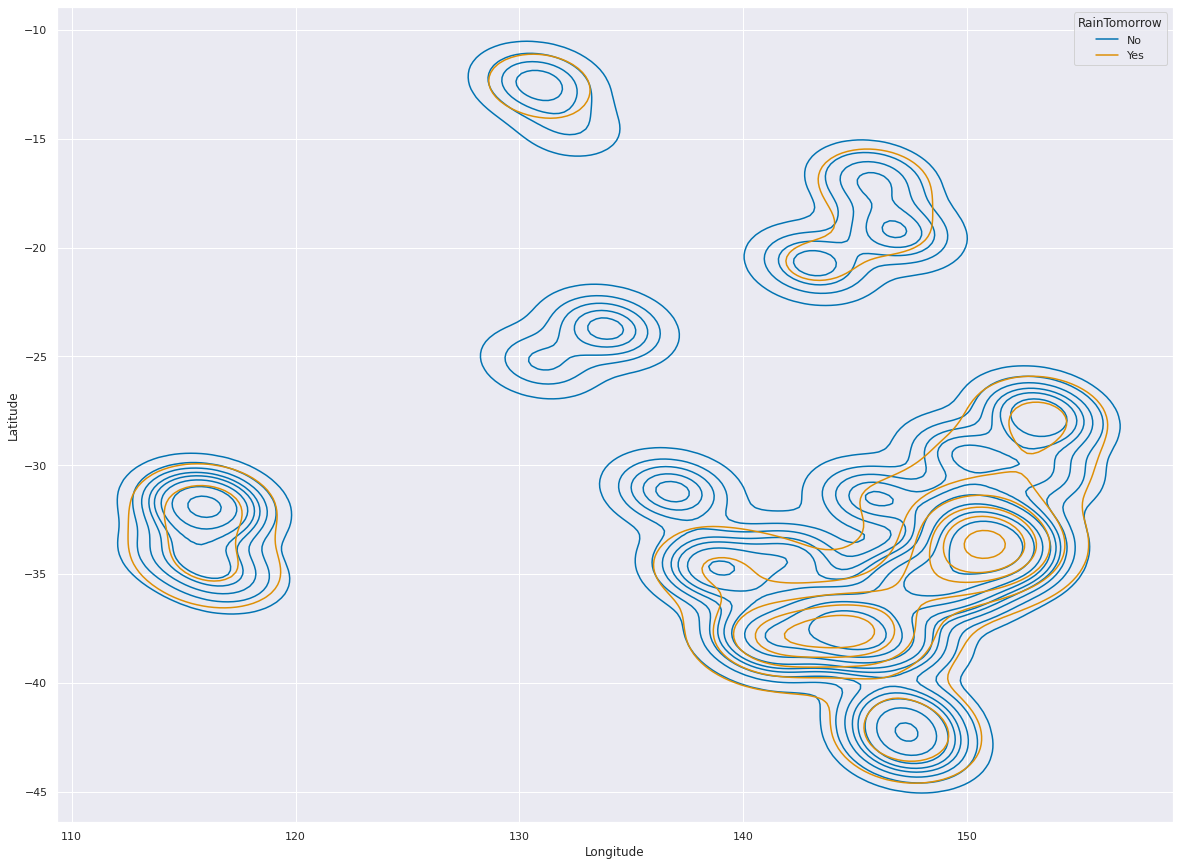

In [99]:
plt.figure(figsize=(20,15))
sns.kdeplot(data = df, x = 'Longitude',y = 'Latitude',hue = 'RainTomorrow')

* It rains more often in the southeastern area than in other regions.

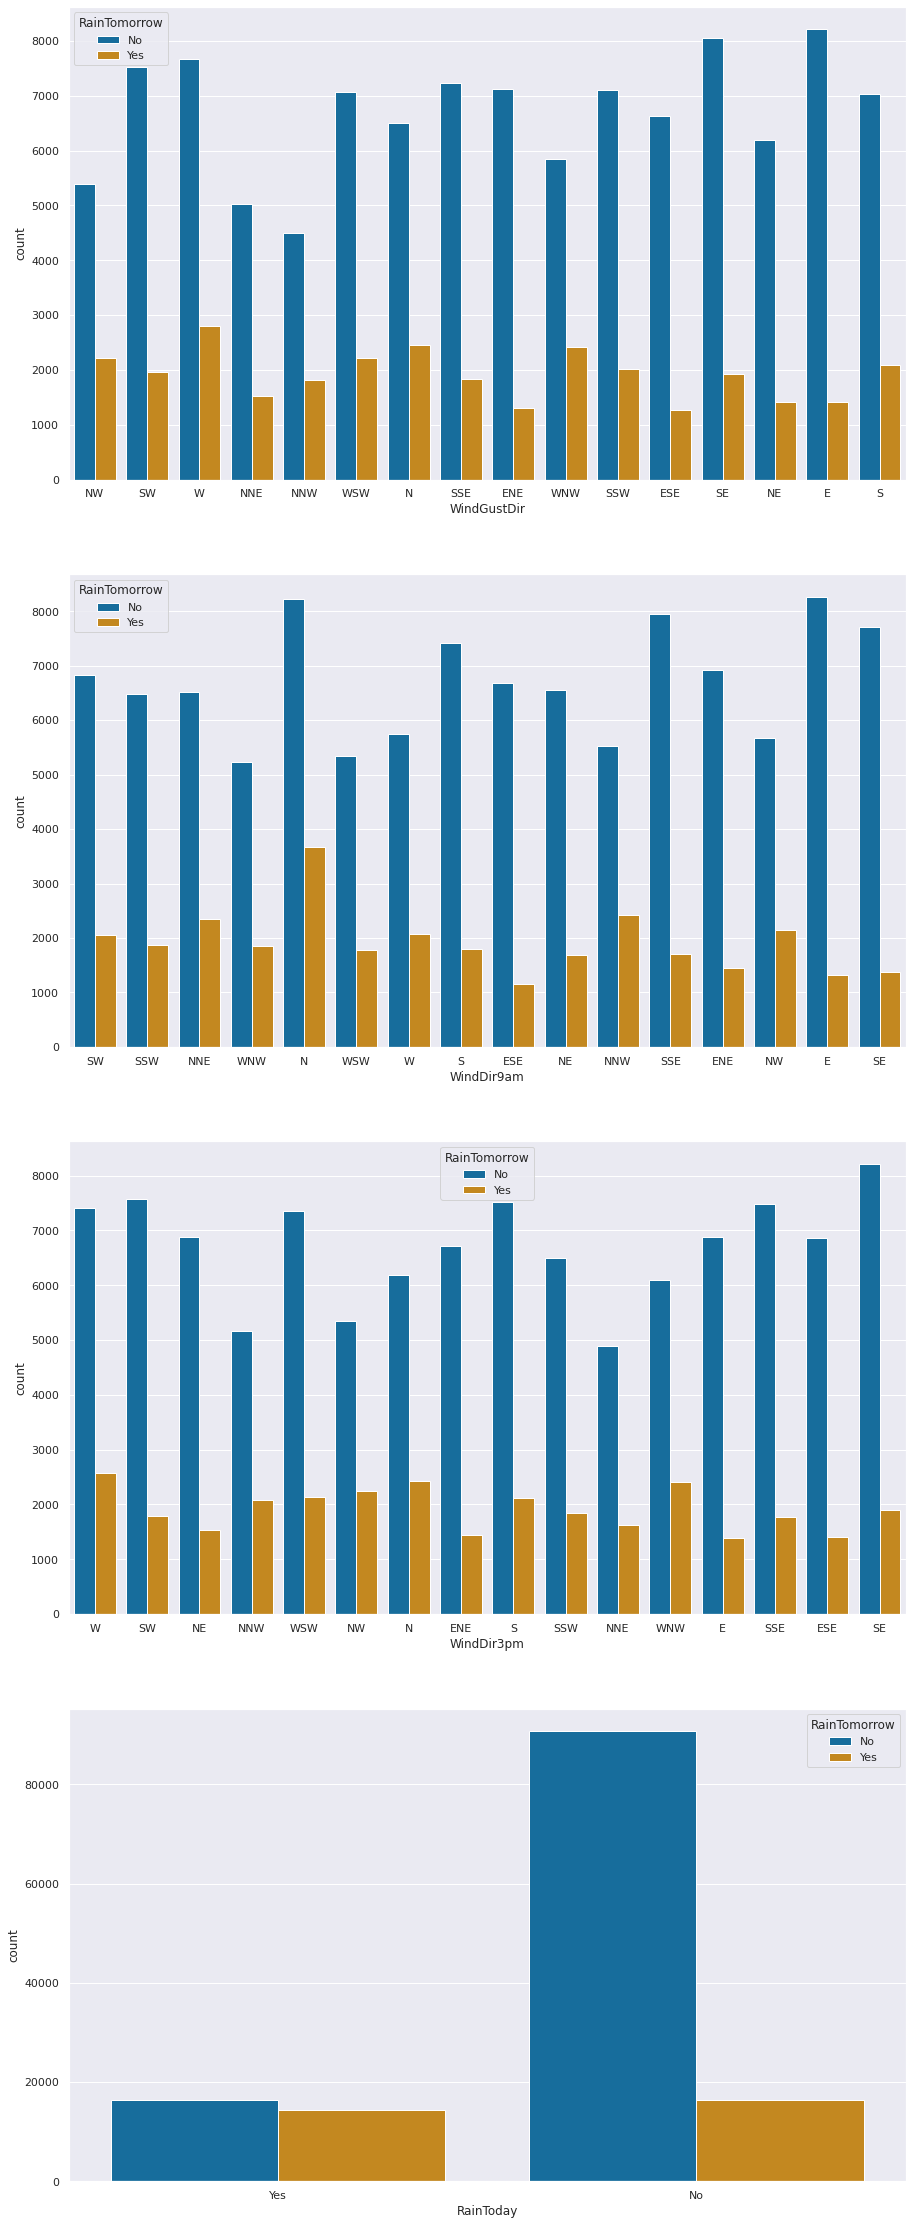

In [100]:
fig, axes = plt.subplots(4,1,figsize=(15, 40))
for i,col in enumerate(cat_cols):
    chart = sns.countplot(ax =axes[i],x= col ,hue = 'RainTomorrow' ,data = df)

* It is more likely to rain tomorrow if it rains today.

# Make Prediction with XGBoost

Let's convert wind directions into angles first.

In [101]:
dirangle_map = {'N':0, 'NNE':22.5, 'NE':45, 'ENE':67.5, 'E':90, 'ESE': 112.5, 'SE':135, 'SSE':157.5, 'S':180, 'SSW':202.5, 'SW':225, 'WSW':247.5, 'W':270, 'WNW':292.5, 'NW':315, 'NNW':337.5 }
bool_map = {'No':0, 'Yes':1}
df.replace({"WindGustDir": dirangle_map, 'WindDir9am':dirangle_map, 'WindDir3pm':dirangle_map, 'RainToday':bool_map, 'RainTomorrow':bool_map }, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137784 entries, 0 to 137783
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   MinTemp        137784 non-null  float64
 1   MaxTemp        137784 non-null  float64
 2   Rainfall       137784 non-null  float64
 3   WindGustDir    137784 non-null  float64
 4   WindGustSpeed  137784 non-null  float64
 5   WindDir9am     137784 non-null  float64
 6   WindDir3pm     137784 non-null  float64
 7   WindSpeed9am   137784 non-null  float64
 8   WindSpeed3pm   137784 non-null  float64
 9   Humidity9am    137784 non-null  float64
 10  Humidity3pm    137784 non-null  float64
 11  Pressure9am    137784 non-null  float64
 12  Pressure3pm    137784 non-null  float64
 13  Temp9am        137784 non-null  float64
 14  Temp3pm        137784 non-null  float64
 15  RainToday      137784 non-null  int64  
 16  RainTomorrow   137784 non-null  int64  
 17  Latitude       137784 non-nul

In [102]:
rng = 42
X = df.drop(['RainTomorrow'],axis = 1)
y = df['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rng,stratify =y)

Here, we fix the learning rate of the XGBClassifier at 0.1 and search for the optimal max_depth and n_estimators with RandomizedSearchCV.

In [103]:
param_grid = {
    'max_depth': range(2, 13),
    'n_estimators':range(300, 1500)
}
clf = xgb.XGBClassifier(eta = 0.1)
randomized_clf = RandomizedSearchCV(estimator=clf,param_distributions=param_grid,scoring = 'accuracy',n_iter = 7, cv = 3, random_state = rng)
randomized_clf.fit(X_train,y_train)

[22:16:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:17:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:17:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:18:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, eta=0.1,
                                           gamma=None, gpu_id=None,
                                           importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_st

Best parameters:  {'n_estimators': 1464, 'max_depth': 11}
Best Score:  0.8814446538667235


<AxesSubplot:>

<Figure size 1440x1080 with 0 Axes>

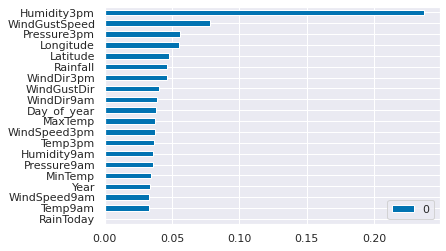

In [104]:
print("Best parameters: ", randomized_clf.best_params_)
print("Best Score: ", randomized_clf.best_score_)
features = pd.DataFrame(randomized_clf.best_estimator_.feature_importances_,index = X.columns)
features.sort_values(by = 0, ascending = True, inplace = True)
plt.figure(figsize=(20,15))
features.plot(kind = 'barh')

* The best hyperparameters found by RandomizedSearchCV are 1464 estimators and max_depth of 11.
* Humidity3pm is the most important featues followed by WindGustSpeed, Pressure3pm, and Lontitude.

              precision    recall  f1-score   support

           0       0.91      0.95      0.93     21417
           1       0.81      0.66      0.72      6140

    accuracy                           0.89     27557
   macro avg       0.86      0.80      0.83     27557
weighted avg       0.88      0.89      0.88     27557



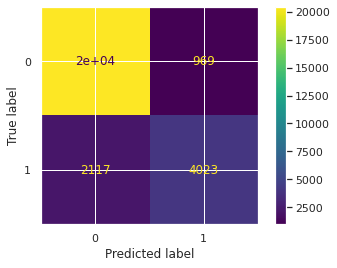

In [105]:
y_pred = randomized_clf.best_estimator_.predict(X_test)
plot_confusion_matrix(randomized_clf.best_estimator_, X_test, y_test)
print(classification_report(y_test,y_pred))

* The model has an 89% accuracy rate on the predictions of the test set.
